# Euro-Coin Classifier


## Check if the GPU is being used

In [6]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


## Required imports and previous configuration

In [7]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

## Data augmentation with generator

In [18]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array


image_size = (200, 200) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,         # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorio con las imagenese originales
source_dir = '../datasets/coins_final/all'

# Directorio de salida para las imágenes aumentadas
augmented_dir = '../datasets/coins_final/augmented_all'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='png'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(source_dir, augmented_dir, data_augmentation)



In [19]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (200, 200) 
batch_size = 64
data_dir = os.path.join('..','datasets', 'coins_final', 'augmented_all')

train_dir = os.path.join('../datasets/ButterflyMoths/augmented_train/') 
valid_dir = os.path.join('../datasets/ButterflyMoths/augmented_valid/') 
test_dir = os.path.join('../datasets/ButterflyMoths/test') 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
# '''

Found 8267 files belonging to 8 classes.
Using 6614 files for training.
Found 8267 files belonging to 8 classes.
Using 1653 files for validation.


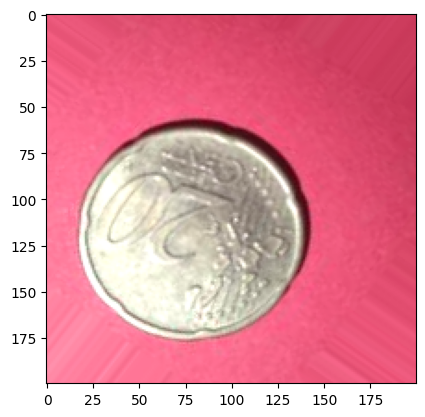

In [21]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('../datasets/coins_final/augmented_all/20c/20c_0_1210.png', 'r')
imshow(np.asarray(pil_im))

## Model definition and configuration 

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(200,200,3)))

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


## Training

In [23]:
epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es],
        # steps_per_epoch=200
)

# model = tf.keras.models.load_model('trained_models/coins_model.h5') # Load the model
model.save('trained_models/coins_model.h5')  # Save as HDF5 file

Epoch 1/100


104/104 [==============================] - 15s 121ms/step - loss: 2.0659 - accuracy: 0.1529 - val_loss: 2.0233 - val_accuracy: 0.1391
Epoch 2/100
104/104 [==============================] - 10s 94ms/step - loss: 1.9338 - accuracy: 0.2200 - val_loss: 1.6881 - val_accuracy: 0.3333
Epoch 3/100
104/104 [==============================] - 10s 95ms/step - loss: 1.5701 - accuracy: 0.3703 - val_loss: 1.4923 - val_accuracy: 0.3914
Epoch 4/100
104/104 [==============================] - 10s 95ms/step - loss: 1.3618 - accuracy: 0.4651 - val_loss: 1.1708 - val_accuracy: 0.5675
Epoch 5/100
104/104 [==============================] - 10s 93ms/step - loss: 1.1846 - accuracy: 0.5445 - val_loss: 1.0738 - val_accuracy: 0.5953
Epoch 6/100
104/104 [==============================] - 10s 93ms/step - loss: 1.0066 - accuracy: 0.6200 - val_loss: 0.9496 - val_accuracy: 0.6304
Epoch 7/100
104/104 [==============================] - 10s 95ms/step - loss: 0.9927 - accuracy: 0.6312 - val_loss: 0.8669 - val_accuracy: 0.6

## Graphical representation of results

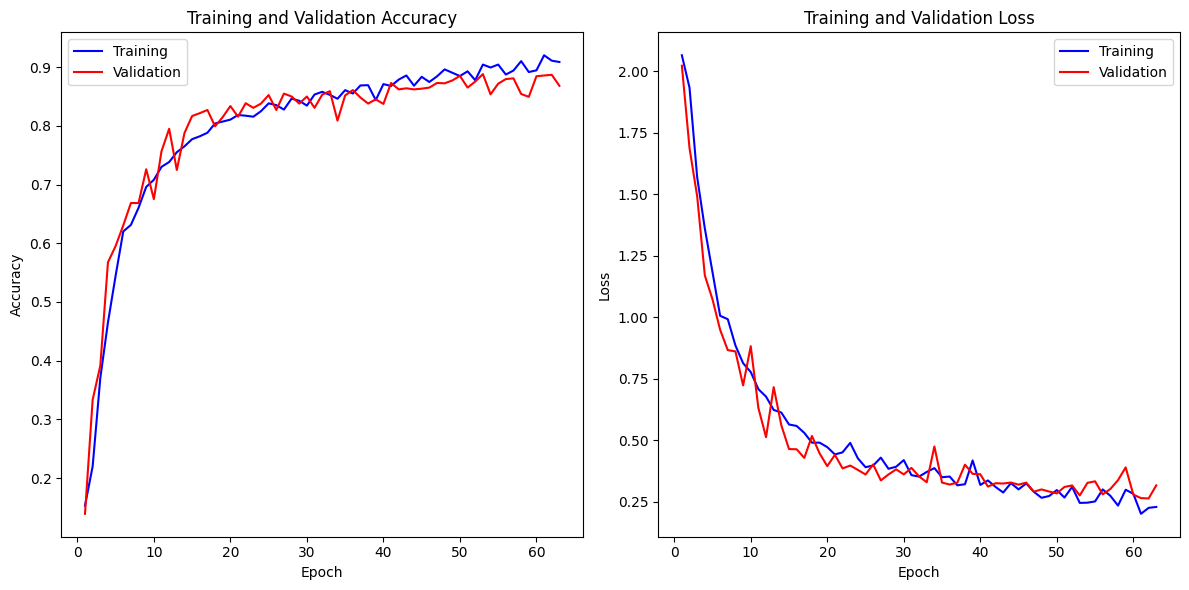

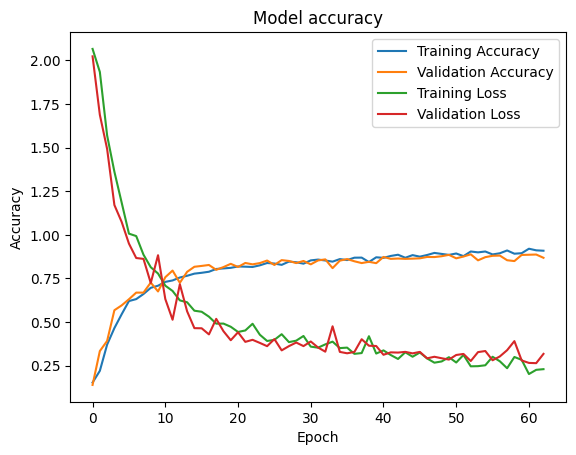

In [24]:
import matplotlib.pyplot as plt

def separate_plot(h):
    # Extracción de datos
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def combined_plot(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model accuracy')    
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
    plt.show()

#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h)

# Generate combined results plot
combined_plot(h)

## Evaluation of results

Found 1746 files belonging to 8 classes.
2/2 [==============================] - 0s 306ms/step


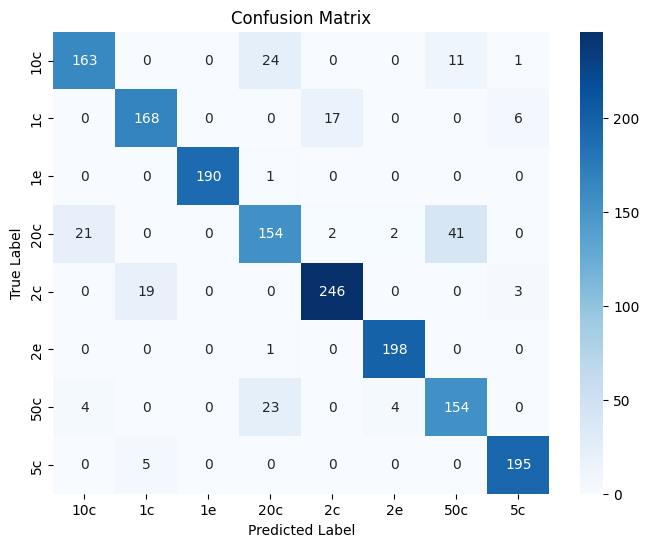

              precision    recall  f1-score   support

         10c     0.8670    0.8191    0.8424       199
          1c     0.8750    0.8796    0.8773       191
          1e     1.0000    0.9948    0.9974       191
         20c     0.7586    0.7000    0.7281       220
          2c     0.9283    0.9179    0.9231       268
          2e     0.9706    0.9950    0.9826       199
         50c     0.7476    0.8324    0.7877       185
          5c     0.9512    0.9750    0.9630       200

    accuracy                         0.8881      1653
   macro avg     0.8873    0.8892    0.8877      1653
weighted avg     0.8881    0.8881    0.8876      1653



In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory

def split_labels(labels, max_length):
    """
    Format long labels by adding line breaks.

    Args:
    labels (list of str): Original list of labels.
    max_length (int): Maximum line length in a label.

    Returns:
    list of str: Labels with line breaks added.
    """
    formatted_labels = []
    for label in labels:
        if len(label) <= max_length:
            formatted_labels.append(label)
            continue

        # Split label into words and construct new label with line breaks
        words = label.split()
        new_label = words[0]
        for word in words[1:]:
            if len(new_label + ' ' + word) <= max_length:
                new_label += ' ' + word
            else:
                new_label += '\n' + word
        formatted_labels.append(new_label)
    
    return formatted_labels


def evaluate_model(train_dir, model, val_ds, max_label_length=15):
    """
    Function to evaluate a model with a validation dataset.
    Displays the confusion matrix and classification report.

    Args:
    train_dir (str): Training data directory to load class names.
    model (keras.Model): Model to evaluate.
    val_ds (tf.data.Dataset): Validation dataset.
    max_label_length (int): Maximum allowed label length before splitting at word boundaries.
    """
    # Load class names and plit long labels at word boundaries
    class_names = split_labels(labels=image_dataset_from_directory(directory=train_dir).class_names,
                               max_length= max_label_length)
    
    # Generate predictions and true labels
    results = np.concatenate([(y.numpy(), model.predict(x)) for x, y in val_ds], axis=1)
    predictions = np.argmax(results[1], axis=1)
    labels = np.argmax(results[0], axis=1)

    # Calculate the confusion matrix with formatted labels
    cf_matrix = confusion_matrix(labels, predictions)

    # Create a heatmap for the confusion matrix with formatted labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
                          xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Display the classification report with formatted labels
    formatted_labels = split_labels(class_names, max_label_length)
    formatted_classification_report = classification_report(labels, predictions, target_names=formatted_labels, digits=4)
    print(formatted_classification_report)


train_dir = os.path.join('../datasets/coins_final/all') 
# Example usage:
evaluate_model(train_dir, model, val_ds, max_label_length=11)


# VGG16 (Visual Geometry Group) CNN-Net

## Model configuration and training

**Explanation of "Inference Mode"**

When it's said that the "base model is in inference mode," it means that the model is being used for making predictions (inferences) rather than for training. This is important when using a pretrained model and only wanting to fine-tune the last layers without modifying the previously learned weights in the earlier layers.

In TensorFlow and Keras, this is achieved by setting `training=False` when calling the base model. This way, the model won't update its weights during the backpropagation process, preserving the previously learned weights.

**Other Modes:**

1. **Training Mode**: This is when `training=True`. In this mode, all training-related operations, such as gradient computation and weight updates, are active.

2. **Inference Mode**: `training=False` indicates that the model is being used to make predictions. Training-specific operations like dropout or batch normalization layers behave differently in this mode to reflect that the model is not being trained.

Using the correct mode is crucial for achieving the expected results, especially when working with pretrained models and performing fine-tuning.

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(
    weights='imagenet', 
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG16 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning, as
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG16 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_VGG16.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg16 = model_with_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

# Save the trained model
model_with_VGG16.save('trained_models/coins_model_with_VGG16.h5')  # Save as HDF5 file


Epoch 1/50
79/79 [==============================] - 18s 224ms/step - loss: 1.4900 - accuracy: 0.6015 - val_loss: 0.5765 - val_accuracy: 0.8056
Epoch 2/50
79/79 [==============================] - 19s 246ms/step - loss: 0.3885 - accuracy: 0.8668 - val_loss: 0.3860 - val_accuracy: 0.8645
Epoch 3/50
79/79 [==============================] - 18s 230ms/step - loss: 0.2389 - accuracy: 0.9195 - val_loss: 0.3293 - val_accuracy: 0.8876
Epoch 4/50
79/79 [==============================] - 18s 226ms/step - loss: 0.1599 - accuracy: 0.9480 - val_loss: 0.2553 - val_accuracy: 0.9179
Epoch 5/50
79/79 [==============================] - 20s 254ms/step - loss: 0.1016 - accuracy: 0.9725 - val_loss: 0.2216 - val_accuracy: 0.9251
Epoch 6/50
79/79 [==============================] - 19s 240ms/step - loss: 0.0653 - accuracy: 0.9861 - val_loss: 0.2219 - val_accuracy: 0.9291
Epoch 7/50
79/79 [==============================] - 19s 236ms/step - loss: 0.0462 - accuracy: 0.9936 - val_loss: 0.2017 - val_accuracy: 0.9323

## Graphical representation of results

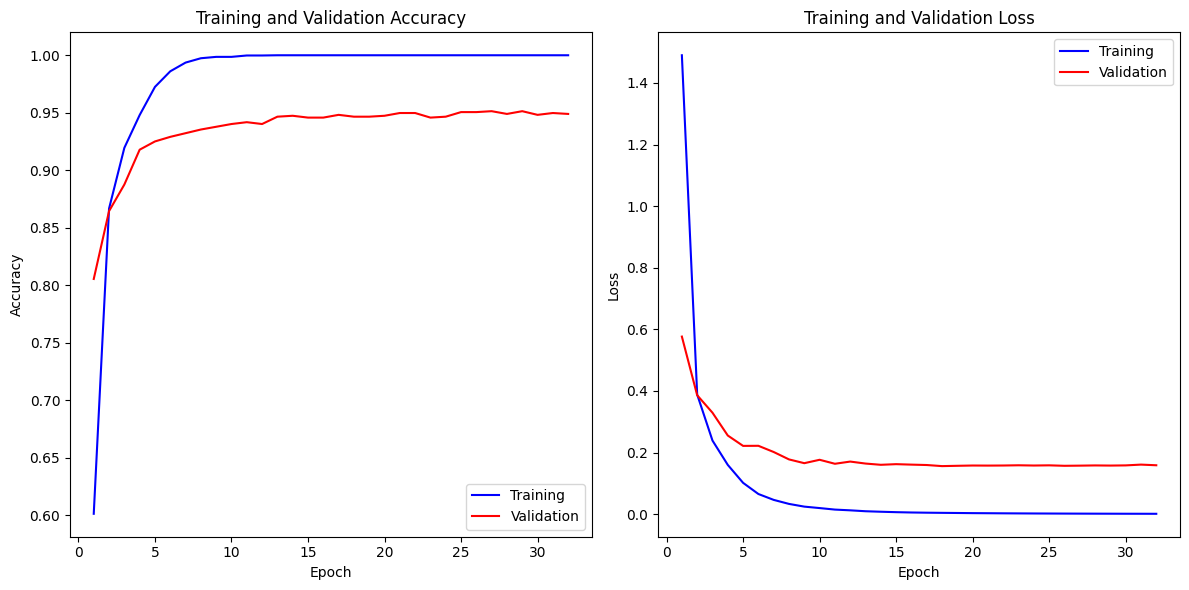

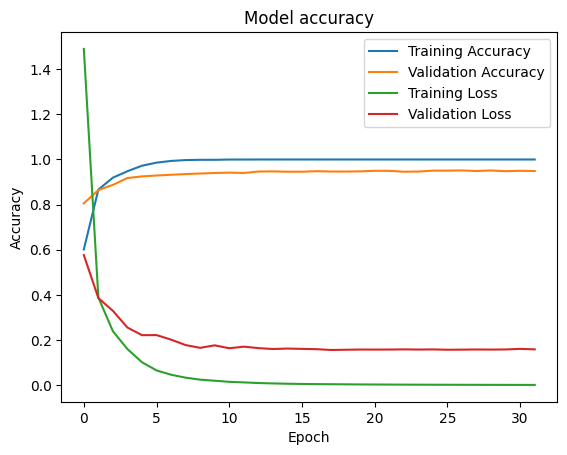

In [33]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h_vgg16)

# Generate combined results plot
combined_plot(h_vgg16)

## Evaluation of results

Found 1637 files belonging to 8 classes.
2/2 [==============================] - 0s 81ms/step


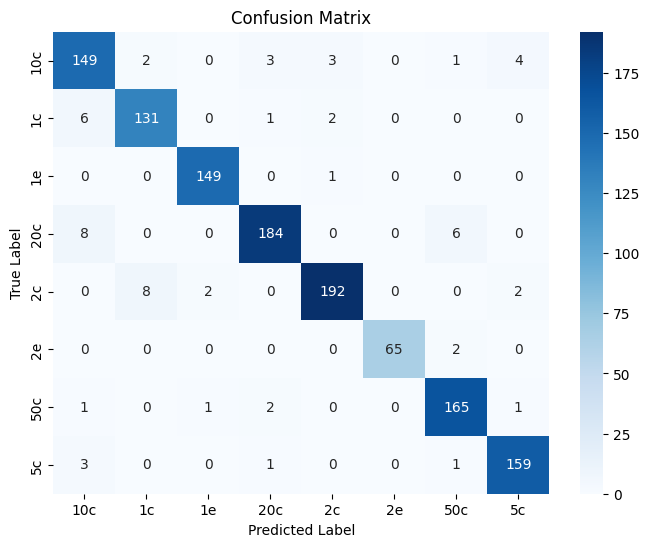

              precision    recall  f1-score   support

         10c     0.8922    0.9198    0.9058       162
          1c     0.9291    0.9357    0.9324       140
          1e     0.9803    0.9933    0.9868       150
         20c     0.9634    0.9293    0.9460       198
          2c     0.9697    0.9412    0.9552       204
          2e     1.0000    0.9701    0.9848        67
         50c     0.9429    0.9706    0.9565       170
          5c     0.9578    0.9695    0.9636       164

    accuracy                         0.9514      1255
   macro avg     0.9544    0.9537    0.9539      1255
weighted avg     0.9519    0.9514    0.9515      1255



In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(train_dir, model_with_VGG16, val_ds, max_label_length=11)


# VGG19 (Visual Geometry Group) CNN-Net

## Model configuration and training

In [28]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG19 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG19 = keras.Model(inputs=input_layer, outputs=output_layer)
model_with_VGG19.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg19 = model_with_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

model_with_VGG19.save('trained_models/coins_model_with_VGG19.h5')  # Save as HDF5 file


Epoch 1/10
79/79 [==============================] - 21s 253ms/step - loss: 1.4807 - accuracy: 0.6142 - val_loss: 0.6635 - val_accuracy: 0.7737
Epoch 2/10
79/79 [==============================] - 20s 248ms/step - loss: 0.4303 - accuracy: 0.8500 - val_loss: 0.4248 - val_accuracy: 0.8502
Epoch 3/10
79/79 [==============================] - 21s 269ms/step - loss: 0.2508 - accuracy: 0.9108 - val_loss: 0.3390 - val_accuracy: 0.8829
Epoch 4/10
79/79 [==============================] - 20s 252ms/step - loss: 0.1855 - accuracy: 0.9369 - val_loss: 0.3477 - val_accuracy: 0.8733
Epoch 5/10
79/79 [==============================] - 19s 244ms/step - loss: 0.1325 - accuracy: 0.9574 - val_loss: 0.2866 - val_accuracy: 0.9004
Epoch 6/10
79/79 [==============================] - 19s 244ms/step - loss: 0.0821 - accuracy: 0.9803 - val_loss: 0.2509 - val_accuracy: 0.9171
Epoch 7/10
79/79 [==============================] - 19s 242ms/step - loss: 0.0561 - accuracy: 0.9910 - val_loss: 0.2382 - val_accuracy: 0.9235

## Graphical representation of results

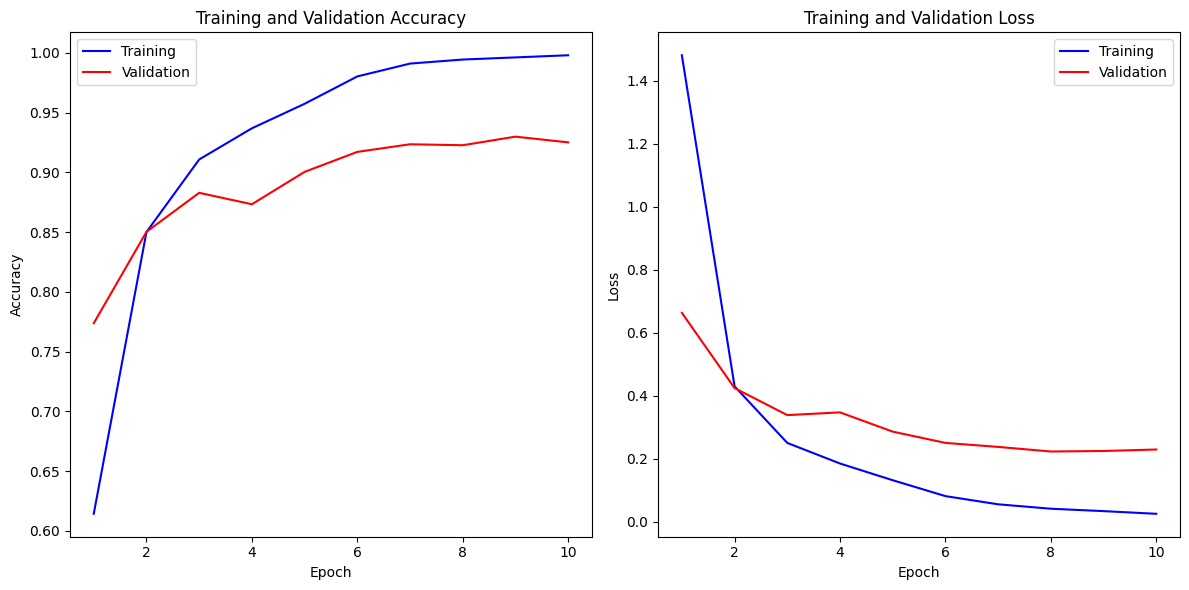

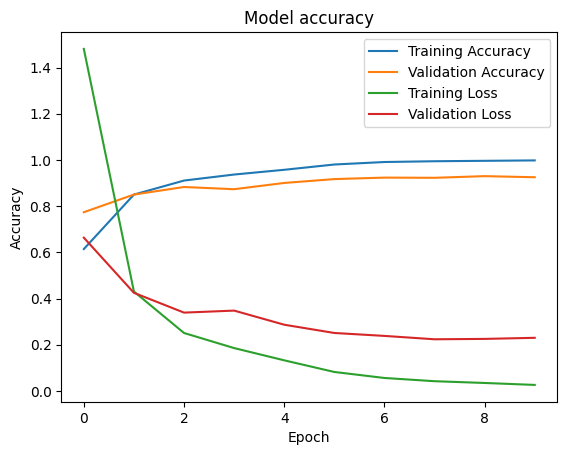

In [35]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h_vgg19)

# Generate combined results plot
combined_plot(h_vgg19)

## Evaluation of results

Found 1637 files belonging to 8 classes.
2/2 [==============================] - 0s 101ms/step


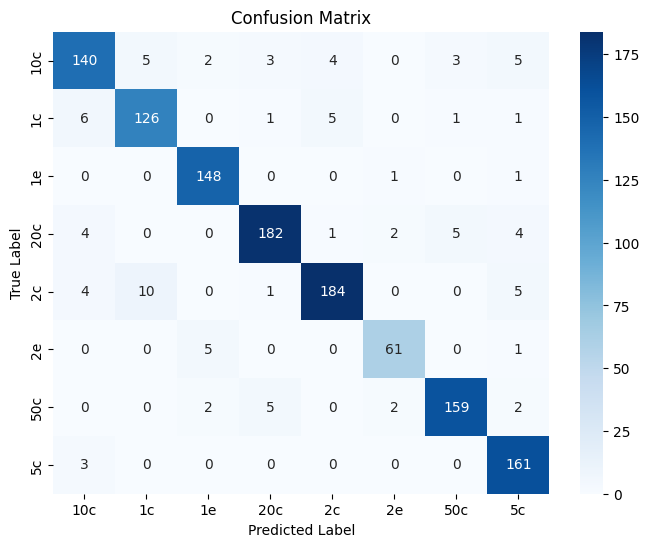

              precision    recall  f1-score   support

         10c     0.8917    0.8642    0.8777       162
          1c     0.8936    0.9000    0.8968       140
          1e     0.9427    0.9867    0.9642       150
         20c     0.9479    0.9192    0.9333       198
          2c     0.9485    0.9020    0.9246       204
          2e     0.9242    0.9104    0.9173        67
         50c     0.9464    0.9353    0.9408       170
          5c     0.8944    0.9817    0.9360       164

    accuracy                         0.9251      1255
   macro avg     0.9237    0.9249    0.9239      1255
weighted avg     0.9256    0.9251    0.9249      1255



In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(train_dir, model_with_VGG19, val_ds, max_label_length=11)


# ResNet50 (Residual Neural Network) CNN-Net

## Model configuration and training

In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the ResNet50 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = Input(shape=(200, 200, 3))

# Use the base model as a feature extractor: Setting training=False ensures that it operates in inference mode.
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
pooled_features = GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = Dense(256, activation='relu')(pooled_features)

# Output layer for classification into 8 classes
output_layer = Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_resnet50 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es_callback = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
history_resnet50 = model_with_resnet50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es_callback]
)

model_with_resnet50.save('trained_models/coins_model_with_resnet50.h5')  # Save as HDF5 file


Epoch 1/50
79/79 [==============================] - 13s 141ms/step - loss: 0.8112 - accuracy: 0.7116 - val_loss: 0.4221 - val_accuracy: 0.8582
Epoch 2/50
79/79 [==============================] - 10s 127ms/step - loss: 0.2880 - accuracy: 0.9062 - val_loss: 0.2820 - val_accuracy: 0.9084
Epoch 3/50
79/79 [==============================] - 10s 125ms/step - loss: 0.1883 - accuracy: 0.9422 - val_loss: 0.2456 - val_accuracy: 0.9108
Epoch 4/50
79/79 [==============================] - 10s 125ms/step - loss: 0.1312 - accuracy: 0.9669 - val_loss: 0.1817 - val_accuracy: 0.9426
Epoch 5/50
79/79 [==============================] - 10s 126ms/step - loss: 0.0955 - accuracy: 0.9753 - val_loss: 0.1612 - val_accuracy: 0.9450
Epoch 6/50
79/79 [==============================] - 10s 125ms/step - loss: 0.0767 - accuracy: 0.9807 - val_loss: 0.1726 - val_accuracy: 0.9355
Epoch 7/50
79/79 [==============================] - 10s 126ms/step - loss: 0.0526 - accuracy: 0.9904 - val_loss: 0.1339 - val_accuracy: 0.9586

## Graphical representation of results

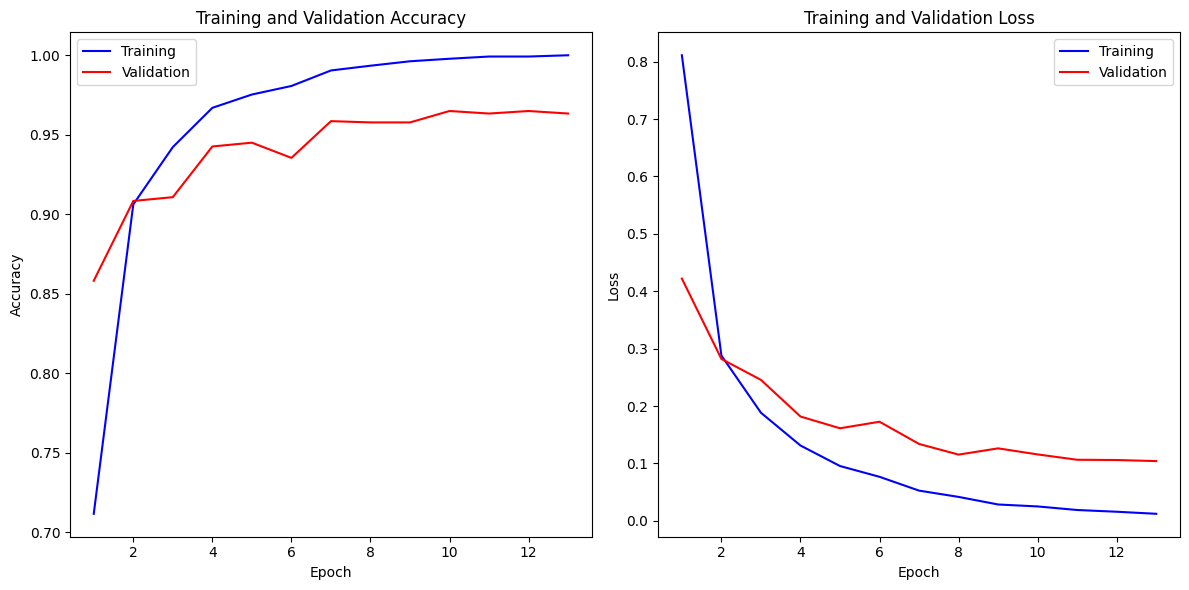

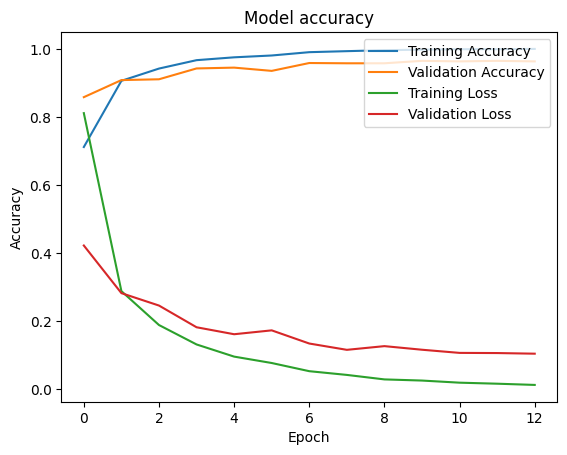

In [39]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(history_resnet50)

# Generate combined results plot
combined_plot(history_resnet50)

## Evaluation of results

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(train_dir, model_with_resnet50, val_ds, max_label_length=11)
